The notebook uses pyWPH version 1.0

In [1]:
! pip install pywph==1.0

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pywph as pw
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import time
import scipy.optimize as opt

In [3]:
# importing files from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
mstar = np.load('drive/MyDrive/camels data/Maps_Mstar_SIMBA_LH_z=0.00.npy')

In [5]:
mstar_data = np.copy(mstar[0])

In [6]:
mstar_flat = mstar_data.flatten()
l = mstar_flat.size

In [7]:
for i in range(l):
  if mstar_flat[i] == 0:
    mstar_flat[i] += 0.1

In [8]:
mstar_data = mstar_flat.reshape(mstar[0].shape)
mstar_data = np.log(mstar_data)

(256, 256)


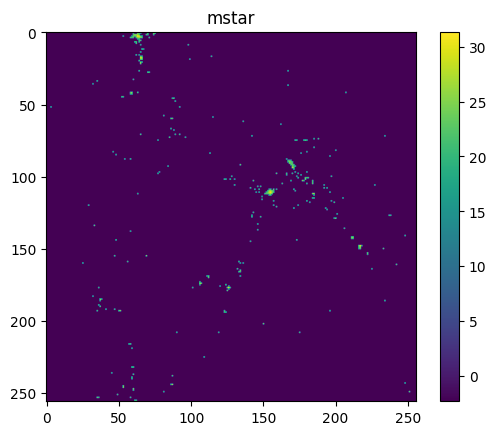

In [9]:
data = mstar_data
print(data.shape)

plt.title('mstar')
plt.imshow(data)
plt.colorbar()

In [10]:
M = 256
N = 256
J = 7
L = 4
dn =0

wph_op = pw.WPHOp(M, N, J, L=L, dn=dn) # operator
coeff = wph_op(data) # get coefficients

In [11]:
# run on a GPU device
if torch.cuda.is_available():
    wph_op.to(0)

In [12]:
wph = wph_op(data, ret_wph_obj=True) # WPH object
print(wph)
# easier to get coefficients

In [13]:
# obtain coefficients and their corresponding indices
s11, s11_in = wph.get_coeffs("S11")
s00, s00_in = wph.get_coeffs("S00")
s01, s01_in = wph.get_coeffs("S01")
c01, c01_in = wph.get_coeffs("C01")
cphase,cphase_in = wph.get_coeffs("Cphase")

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


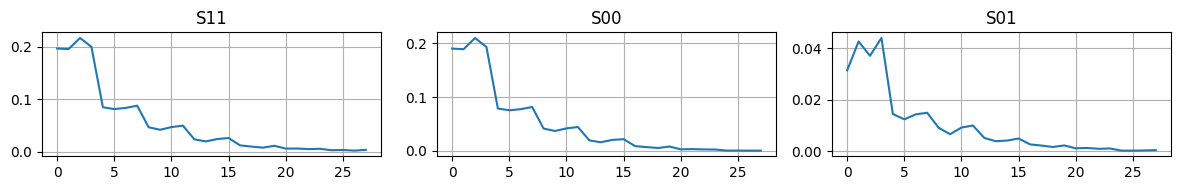

In [14]:
# s coefficients
fig, axs = plt.subplots(1, 3, figsize=(12, 2))

axs[0].plot(s11)
axs[1].plot(s00)
axs[2].plot(s01)

axs[0].set_title('S11')
axs[1].set_title('S00')
axs[2].set_title('S01')
axs[0].grid()
axs[1].grid()
axs[2].grid()

fig.tight_layout()
fig.show()

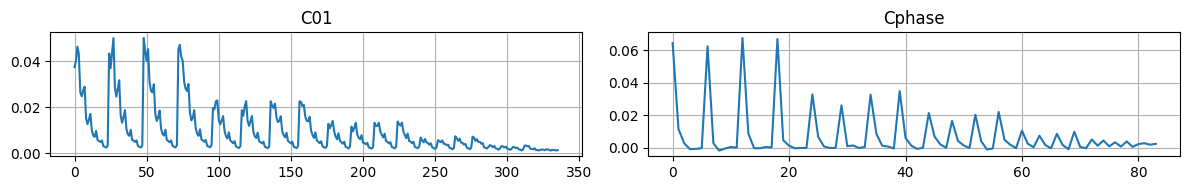

In [15]:
# c coefficients
fig, axs = plt.subplots(1, 2, figsize=(12, 2))
axs[0].plot(c01)
axs[1].plot(cphase)

axs[0].set_title('C01')
axs[1].set_title('Cphase')
axs[0].grid()
axs[1].grid()

fig.tight_layout()
fig.show()

In [16]:
# generate a noise image as an initial guess
guess = np.random.normal(data.mean(), data.std(), data.shape)

coeff = wph_op(data,norm='auto') # normalise data coefficients
print(coeff.shape)
print(guess.shape)

torch.Size([520])
(256, 256)


In [17]:
# optimizer

count = 0

def objective(y):
    global count
    print(f"Evaluation: {count}")
    start_time = time.time()
    loss_tot = torch.zeros(1)

    Y = y.reshape((M, N)) # reshape y

    # calculate loss
    Y, chunks = wph_op.preconfigure(Y, requires_grad=True)
    for i in range(chunks):
        y_coeffs_chunk, indices = wph_op(Y, i, norm='auto', ret_indices=True) # get coefficients and indice
        loss = torch.sum(torch.abs(y_coeffs_chunk - coeff[indices])** 2) # compute residual
        loss.backward(retain_graph=True)
        loss_tot += loss.detach().cpu()
        del y_coeffs_chunk, indices, loss

    y_final = Y.grad.cpu().numpy().astype(y.dtype) # reshape gradient
    print(f"Loss: {loss_tot.item()} (computed in {(time.time() - start_time):.2f}s)")
    count += 1
    return loss_tot.item(), y_final.ravel()


In [18]:
# run optimizer
result = opt.minimize(objective, guess.ravel(), method='L-BFGS-B', jac=True, tol=None, options={"maxiter": 50, "gtol": 1e-14, "ftol": 1e-14, "maxcor": 20})
final_loss, final_guess, niter, msg = result['fun'], result['x'], result['nit'], result['message']
final_guess = final_guess.reshape(guess.shape)
print(f"Synthesis ended in {niter} iterations with optimizer message: {msg}")

Evaluation: 0
Loss: 98.11515808105469 (computed in 0.18s)


/usr/local/lib/python3.10/dist-packages/pywph/wph_operator.py:774: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:276.)
  xpsi1_k1 -= mean1.to(xpsi1_k1.dtype) # Consistent dtype needed


Evaluation: 1
Loss: 96.53863525390625 (computed in 0.17s)
Evaluation: 2
Loss: 91.5634536743164 (computed in 0.17s)
Evaluation: 3
Loss: 86.24305725097656 (computed in 0.18s)
Evaluation: 4
Loss: 84.30662536621094 (computed in 0.18s)
Evaluation: 5
Loss: 70.20011138916016 (computed in 0.17s)
Evaluation: 6
Loss: 71882.25 (computed in 0.18s)
Evaluation: 7
Loss: 71.43609619140625 (computed in 0.18s)
Evaluation: 8
Loss: 59.05973434448242 (computed in 0.18s)
Evaluation: 9
Loss: 58.5536994934082 (computed in 0.17s)
Evaluation: 10
Loss: 52.46418762207031 (computed in 0.19s)
Evaluation: 11
Loss: 1058.154541015625 (computed in 0.18s)
Evaluation: 12
Loss: 54.76833724975586 (computed in 0.20s)
Evaluation: 13
Loss: 51.11353302001953 (computed in 0.18s)
Evaluation: 14
Loss: 45.836753845214844 (computed in 0.21s)
Evaluation: 15
Loss: 38.63570022583008 (computed in 0.19s)
Evaluation: 16
Loss: 32.6204833984375 (computed in 0.17s)
Evaluation: 17
Loss: 29.505393981933594 (computed in 0.18s)
Evaluation: 18
L

In [19]:
np.max(final_guess)

63.12252429822466

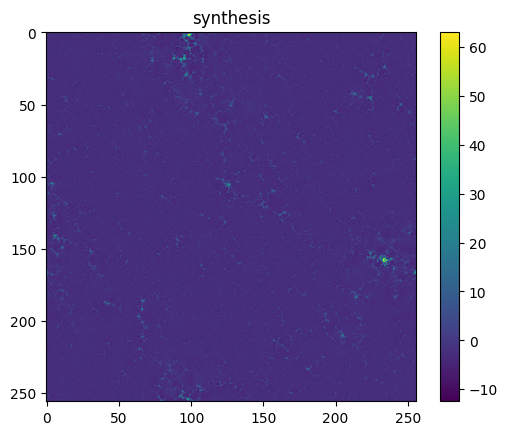

In [20]:
plt.imshow(final_guess)
plt.title('synthesis')
plt.colorbar()

In [21]:
np.max(final_guess)-np.max(data)

31.753807104621146

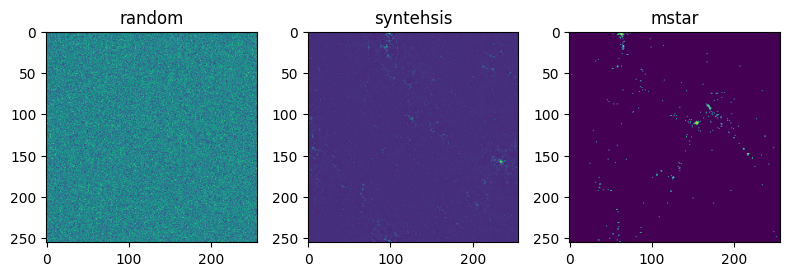

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(8, 8))

axs[0].imshow(guess)
axs[1].imshow(final_guess)
axs[2].imshow(data)

axs[0].set_title('random')
axs[1].set_title('syntehsis')
axs[2].set_title('mstar')


fig.tight_layout()
fig.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


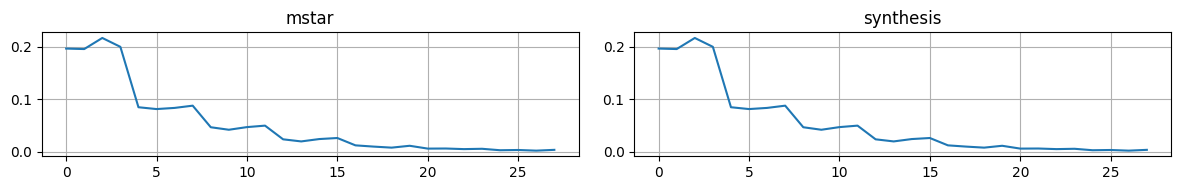

In [23]:
# compare s11 coefficients

wph1 = wph_op(final_guess, ret_wph_obj=True) # WPH object
s11_guess, s11_in_guess = wph.get_coeffs("S11")

fig, axs = plt.subplots(1, 2, figsize=(12, 2))
axs[0].plot(s11)
axs[1].plot(s11_guess)
axs[0].set_title('mstar')
axs[1].set_title('synthesis')
axs[0].grid()
axs[1].grid()

fig.tight_layout()
fig.show()


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


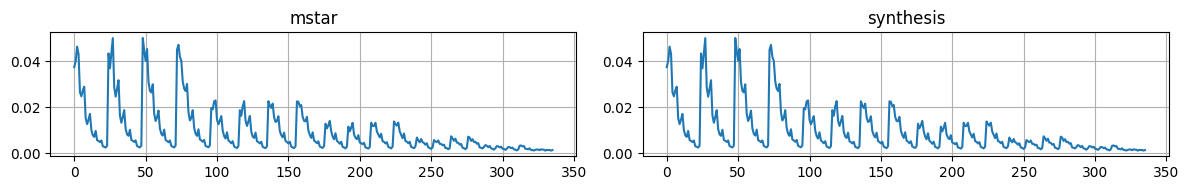

In [24]:
# compare s00 coefficients

wph1 = wph_op(final_guess, ret_wph_obj=True) # WPH object
c01_guess, c01_in_guess = wph.get_coeffs("C01")

fig, axs = plt.subplots(1, 2, figsize=(12, 2))
axs[0].plot(c01)
axs[1].plot(c01_guess)
axs[0].set_title('mstar')
axs[1].set_title('synthesis')
axs[0].grid()
axs[1].grid()

fig.tight_layout()
fig.show()
